In [1]:
!pip install download
#pip uninstall mindspore

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple/

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
from download import download
!wget -c https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/dataset_fcn8s.tar
print("Downloaded")

--2026-02-28 07:07:25--  https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/dataset_fcn8s.tar
Resolving proxy.modelarts.com (proxy.modelarts.com)... 192.168.0.180
Connecting to proxy.modelarts.com (proxy.modelarts.com)|192.168.0.180|:80... connected.
Proxy request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Downloaded


In [3]:
!tar -xf dataset_fcn8s.tar
import psutil
print(psutil.virtual_memory())

svmem(total=540852953088, available=528683384832, percent=2.3, used=10755780608, free=472035303424, active=21420498944, inactive=25997746176, buffers=4493041664, cached=53568827392, shared=144879616, slab=18076082176)


In [4]:
import numpy as np
import cv2
import mindspore.dataset as ds

class SegDataset:
    def __init__(self,
                 image_mean,
                 image_std,
                 data_file='',
                 batch_size=32,
                 crop_size=256,
                 max_scale=2.0,
                 min_scale=0.5,
                 ignore_label=255,
                 num_classes=21,
                 num_readers=2,
                 num_parallel_calls=1):
        
        self.data_file=data_file
        self.batch_size=batch_size
        self.crop_size=crop_size
        self.image_mean=np.array(image_mean, dtype=np.float32)
        self.image_std=np.array(image_std, dtype=np.float32)
        self.max_scale=max_scale
        self.min_scale=min_scale
        self.ignore_label=ignore_label
        self.num_classes=num_classes
        self.num_readers=num_readers
        self.num_parallel_calls=num_parallel_calls
        max_scale>min_scale
        
    def preprocess_dataset(self, image, label):

        image_out = cv2.imdecode(np.frombuffer(image, dtype=np.uint8), cv2.IMREAD_COLOR)
        label_out = cv2.imdecode(np.frombuffer(label, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)

        sc = np.random.uniform(self.min_scale, self.max_scale)

        new_h = int(sc * image_out.shape[0])
        new_w = int(sc * image_out.shape[1])

        image_out = cv2.resize(image_out, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
        label_out = cv2.resize(label_out, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

        image_out = (image_out - self.image_mean) / self.image_std

        out_h = max(new_h, self.crop_size)
        out_w = max(new_w, self.crop_size)

        pad_h = out_h - new_h
        pad_w = out_w - new_w

        if pad_h > 0 or pad_w > 0:
            image_out = cv2.copyMakeBorder(
                image_out, 0, pad_h, 0, pad_w,
                cv2.BORDER_CONSTANT, value=0
            )

            label_out = cv2.copyMakeBorder(
                label_out, 0, pad_h, 0, pad_w,
                cv2.BORDER_CONSTANT, value=self.ignore_label
            )

        offset_h = np.random.randint(0, out_h - self.crop_size + 1)
        offset_w = np.random.randint(0, out_w - self.crop_size + 1)

        image_out = image_out[
            offset_h:offset_h+self.crop_size,
            offset_w:offset_w+self.crop_size,
            :
        ]

        label_out = label_out[
            offset_h:offset_h+self.crop_size,
            offset_w:offset_w+self.crop_size
        ]

        if np.random.uniform(0.0, 1.0) > 0.5:
            image_out = image_out[:, ::-1, :]
            label_out = label_out[:, ::-1]

        image_out = image_out.transpose((2, 0, 1))
        image_out = image_out.copy()

        label_out = label_out.astype("int32")
        label_out = label_out.copy()

        return image_out, label_out
    def get_dataset(self):
        ds.config.set_numa_enable(True)
        dataset=ds.MindDataset(self.data_file, columns_list=["data","label"],shuffle=True, num_parallel_workers=self.num_readers)
        transforms_list=self.preprocess_dataset
        
        dataset=dataset.map(operations=transforms_list, input_columns=["data", "label"],
                               output_columns=["data","label"], num_parallel_workers=self.num_parallel_calls)
        dataset=dataset.shuffle(buffer_size=self.batch_size*10)
        dataset=dataset.batch(self.batch_size, drop_remainder=True)
        return dataset
        

In [5]:
# Define parameters for creating a dataset.
IMAGE_MEAN = [103.53, 116.28, 123.675]
IMAGE_STD = [57.375, 57.120, 58.395]
DATA_FILE = "dataset_fcn8s/mindname.mindrecord"

# Define model training parameters.
train_batch_size = 4
crop_size = 256
min_scale = 0.5
max_scale = 2.0
ignore_label = 255
num_classes = 21

dataset=SegDataset(image_mean=IMAGE_MEAN,
                  image_std=IMAGE_STD,
                  data_file=DATA_FILE,
                  batch_size=train_batch_size,
                  crop_size=crop_size,
                  max_scale=max_scale,
                  min_scale=min_scale,
                  ignore_label=ignore_label,
                  num_classes=num_classes,
                  num_readers=2,
                  num_parallel_calls=4)
dataset=dataset.get_dataset()

set_mempolicy: Operation not permitted
set_mempolicy: Operation not permitted
set_mempolicy: Operation not permitted
set_mempolicy: Operation not permitted
set_mempolicy: Operation not permitted
set_mempolicy: Operation not permitted
set_mempolicy: Operation not permitted
set_mempolicy: Operation not permitted


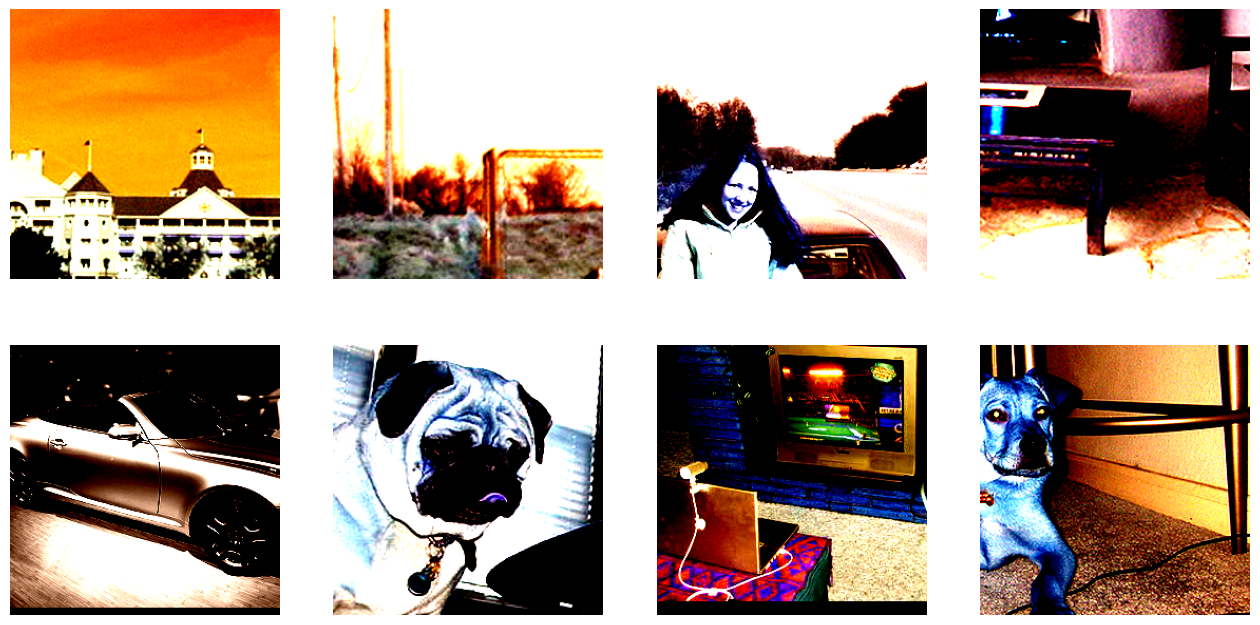

In [6]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
for i in range(1,9):
    plt.subplot(2,4,i)
    show_data=next(dataset.create_dict_iterator())
    show_images=show_data["data"].asnumpy()
    show_images=np.clip(show_images, 0,1)
    #Convert the image to the HWC format and display it
    plt.imshow(show_images[0].transpose(1,2,0))
    plt.axis("off")
    plt.subplots_adjust

In [7]:
import mindspore.nn as nn
import mindspore.ops as ops

class FCN8s(nn.Cell):
    def __init__(self, n_class):
        super().__init__()
        self.n_class = n_class
        self.transpose = ops.Transpose() 
        self.conv1 = nn.SequentialCell(
            nn.Conv2d(in_channels=3, out_channels=64,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.SequentialCell(
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.SequentialCell(
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.SequentialCell(
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.SequentialCell(
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, weight_init='xavier_uniform'),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv6 = nn.SequentialCell(
            nn.Conv2d(in_channels=512, out_channels=4096,
                      kernel_size=7, weight_init='xavier_uniform'),
            nn.BatchNorm2d(4096),
            nn.ReLU(),
        )
        self.conv7 = nn.SequentialCell(
            nn.Conv2d(in_channels=4096, out_channels=4096,
                      kernel_size=1, weight_init='xavier_uniform'),
            nn.BatchNorm2d(4096),
            nn.ReLU(),
        )
        self.score_fr = nn.Conv2d(in_channels=4096, out_channels=self.n_class,
                                  kernel_size=1, weight_init='xavier_uniform')
        self.upscore2 = nn.Conv2dTranspose(in_channels=self.n_class, out_channels=self.n_class,
                                           kernel_size=4, stride=2, weight_init='xavier_uniform')
        self.score_pool4 = nn.Conv2d(in_channels=512, out_channels=self.n_class,
                                     kernel_size=1, weight_init='xavier_uniform')
        self.upscore_pool4 = nn.Conv2dTranspose(in_channels=self.n_class, out_channels=self.n_class,
                                                kernel_size=4, stride=2, weight_init='xavier_uniform')
        self.score_pool3 = nn.Conv2d(in_channels=256, out_channels=self.n_class,
                                     kernel_size=1, weight_init='xavier_uniform')
        self.upscore8 = nn.Conv2dTranspose(in_channels=self.n_class, out_channels=self.n_class,
                                           kernel_size=16, stride=8, weight_init='xavier_uniform')

    def construct(self, x):
        x1 = self.conv1(x)
        p1 = self.pool1(x1)
        x2 = self.conv2(p1)
        p2 = self.pool2(x2)
        x3 = self.conv3(p2)
        p3 = self.pool3(x3)
        x4 = self.conv4(p3)
        p4 = self.pool4(x4)
        x5 = self.conv5(p4)
        p5 = self.pool5(x5)
        x6 = self.conv6(p5)
        x7 = self.conv7(x6)
        sf = self.score_fr(x7)
        u2 = self.upscore2(sf)
        s4 = self.score_pool4(p4)
        f4 = s4 + u2
        u4 = self.upscore_pool4(f4)
        s3 = self.score_pool3(p3)
        f3 = s3 + u4
        out = self.upscore8(f3)
        out = self.transpose(out, (0, 2, 3, 1))

        return out


### Training Prepration

In [8]:
from download import download
from mindspore import load_checkpoint, load_param_into_net

#!wget https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/fcn8s_vgg16_pretrain.ckpt
#download(url, "fcn8s_vgg16_pretrain.ckpt", replace=True)
def load_vgg16():
    ckpt_vgg16 = "fcn8s_vgg16_pretrain.ckpt"
    param_vgg = load_checkpoint(ckpt_vgg16)
    load_param_into_net(net, param_vgg)


In [9]:
import numpy as np
import mindspore as ms
import mindspore.nn as nn
import mindspore.train as train
from mindspore.nn.metrics import Metric

class PixelAccuracy(Metric):
    def __init__(self, num_class=21):
        super(PixelAccuracy, self).__init__()
        self.num_class = num_class

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def clear(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

    def update(self, *inputs):
        y_pred = inputs[0].asnumpy().argmax(axis=3)  # ✅ FIXED
        y = inputs[1].asnumpy()

        self.confusion_matrix += self._generate_matrix(y, y_pred)

    def eval(self):
        pixel_accuracy = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        return pixel_accuracy


class PixelAccuracyClass(Metric):
    def __init__(self, num_class=21):
        super(PixelAccuracyClass, self).__init__()
        self.num_class = num_class

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def update(self, *inputs):
        y_pred = inputs[0].asnumpy().argmax(axis=3)  # ✅ FIXED
        y = inputs[1].asnumpy()

        self.confusion_matrix += self._generate_matrix(y, y_pred)

    def clear(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

    def eval(self):
        mean_pixel_accuracy = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
        mean_pixel_accuracy = np.nanmean(mean_pixel_accuracy)
        return mean_pixel_accuracy


class MeanIntersectionOverUnion(Metric):
    def __init__(self, num_class=21):
        super(MeanIntersectionOverUnion, self).__init__()
        self.num_class = num_class

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def update(self, *inputs):
        y_pred = inputs[0].asnumpy().argmax(axis=3)  # ✅ FIXED
        y = inputs[1].asnumpy()

        self.confusion_matrix += self._generate_matrix(y, y_pred)

    def clear(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

    def eval(self):
        mean_iou = np.diag(self.confusion_matrix) / (
            np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
            np.diag(self.confusion_matrix))
        mean_iou = np.nanmean(mean_iou)
        return mean_iou


class FrequencyWeightedIntersectionOverUnion(Metric):
    def __init__(self, num_class=21):
        super(FrequencyWeightedIntersectionOverUnion, self).__init__()
        self.num_class = num_class

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def update(self, *inputs):
        y_pred = inputs[0].asnumpy().argmax(axis=3)  # ✅ FIXED
        y = inputs[1].asnumpy()

        self.confusion_matrix += self._generate_matrix(y, y_pred)

    def clear(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

    def eval(self):
        freq = np.sum(self.confusion_matrix, axis=1) / np.sum(self.confusion_matrix)
        iu = np.diag(self.confusion_matrix) / (
            np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
            np.diag(self.confusion_matrix))

        frequency_weighted_iou = (freq[freq > 0] * iu[freq > 0]).sum()
        return frequency_weighted_iou


### Model training

In [10]:
#!pip install mindspore
import mindspore
from mindspore import Tensor
import mindspore.nn as nn
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore import Model
import mindspore as ms
from mindspore.train.loss_scale_manager import FixedLossScaleManager

loss_scale_manager = FixedLossScaleManager(1024, True)
train_batch_size = 1
num_classes = 21
# Initialize the model structure.
net = FCN8s(n_class=21)
# Import VGG-16 pre-trained parameters.
load_vgg16()
# Calculate the learning rate.
min_lr = 0.0001
base_lr = 0.01
train_epochs = 4

dataset = SegDataset(image_mean=IMAGE_MEAN,
                     image_std=IMAGE_STD,
                     data_file=DATA_FILE,
                     batch_size=train_batch_size,
                     crop_size=crop_size,
                     max_scale=max_scale,
                     min_scale=min_scale,
                     ignore_label=ignore_label,
                     num_classes=num_classes,
                     num_readers=2,
                     num_parallel_calls=4)
dataset_eval = dataset.get_dataset()
#iters_per_epoch = dataset.get_dataset_size()
iters_per_epoch = dataset_eval.get_dataset_size()
total_step = iters_per_epoch * train_epochs

lr_scheduler = mindspore.nn.cosine_decay_lr(min_lr,
                                            base_lr,
                                            total_step,
                                            iters_per_epoch,
                                            decay_epoch=2)
lr = Tensor(lr_scheduler)

# Define the loss function.
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
# Define the optimizer.
optimizer = nn.Momentum(params=net.trainable_params(), learning_rate=lr, momentum=0.9, weight_decay=0.0001)
# Define loss_scale.
scale_factor = 4
scale_window = 3000

# Initialize the model.
model = Model(net, loss_fn=loss, optimizer=optimizer,
              loss_scale_manager=loss_scale_manager,
              metrics={"pixel accuracy": PixelAccuracy(),
                       "mean pixel accuracy": PixelAccuracyClass(),
                       "mean IoU": MeanIntersectionOverUnion(),
                       "frequency weighted IoU": FrequencyWeightedIntersectionOverUnion()})

model.eval(dataset_eval)

# Set the parameters for saving the CKPT file.
time_callback = TimeMonitor(data_size=iters_per_epoch)
loss_callback = LossMonitor()
callbacks = [time_callback, loss_callback]
save_steps = 330
keep_checkpoint_max = 5
config_ckpt = CheckpointConfig(save_checkpoint_steps=10,
                               keep_checkpoint_max=keep_checkpoint_max)
ckpt_callback = ModelCheckpoint(prefix="FCN8s",
                                directory="./ckpt",
                                config=config_ckpt)
callbacks.append(ckpt_callback)
train_dataset = dataset.get_dataset()
#model.train(train_epochs, train_dataset, callbacks=callbacks)
model.train(train_epochs, train_dataset, callbacks=callbacks)


set_mempolicy: Operation not permitted
set_mempolicy: Operation not permitted
set_mempolicy: Operation not permitted
set_mempolicy: Operation not permitted
[WARNING] KERNEL(263719,7f5312962740,python):2026-02-28-07:09:39.145.770 [mindspore/ccsrc/plugin/device/gpu/kernel/cuda_impl/cuda_class/cuda_class_common.h:55] CalShapesSizeInBytes] For 'Reciprocal', the shapes[0] is ( )


epoch: 1 step: 4575, loss is 8.914666175842285
epoch time: 144133.607 ms, per step time: 31.505 ms
epoch: 2 step: 4575, loss is 0.7769683599472046
epoch time: 140803.406 ms, per step time: 30.777 ms
epoch: 3 step: 4575, loss is 0.4795472025871277
epoch time: 140734.569 ms, per step time: 30.762 ms
epoch: 4 step: 4575, loss is 1.8457320928573608
epoch time: 140708.013 ms, per step time: 30.756 ms


### Model Evaluation

In [11]:

IMAGE_MEAN = [103.53, 116.28, 123.675]
IMAGE_STD = [57.375, 57.120, 58.395]
DATA_FILE = "dataset_fcn8s/mindname.mindrecord"

#!wget -c https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/FCN8s.ckpt

net = FCN8s(n_class=num_classes)

ckpt_file = "FCN8s.ckpt"
param_dict = load_checkpoint(ckpt_file)
load_param_into_net(net, param_dict)

model = Model(net, loss_fn=loss, optimizer=optimizer, loss_scale_manager=loss_scale_manager,
              metrics={"pixel accuracy": PixelAccuracy(), "mean pixel accuracy": PixelAccuracyClass(),
                       "mean IoU": MeanIntersectionOverUnion(), "frequency weighted IoU": FrequencyWeightedIntersectionOverUnion()})

dataset = SegDataset(image_mean=IMAGE_MEAN,
                     image_std=IMAGE_STD,
                     data_file=DATA_FILE,
                     batch_size=train_batch_size,
                     crop_size=crop_size,
                     max_scale=max_scale,
                     min_scale=min_scale,
                     ignore_label=ignore_label,
                     num_classes=num_classes,
                     num_readers=2,
                     num_parallel_calls=4)
dataset_eval = dataset.get_dataset()
model.eval(dataset_eval)


set_mempolicy: Operation not permitted
set_mempolicy: Operation not permitted


{'pixel accuracy': 0.9494358463469448,
 'mean pixel accuracy': 0.8833593754411316,
 'mean IoU': 0.8282384167356627,
 'frequency weighted IoU': 0.904330089707535}

### Model Inference

set_mempolicy: Operation not permitted


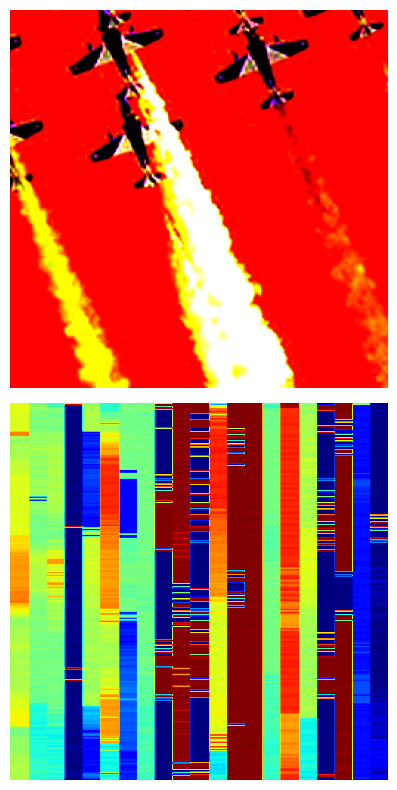

In [16]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

show_data = next(dataset_eval.create_dict_iterator())
show_images = show_data["data"].asnumpy()
show_images = np.clip(show_images, 0, 1)

res = net(show_data["data"]).asnumpy().argmax(axis=1)

batch_size = show_images.shape[0]   # Automatically detect batch size

for i in range(batch_size):
 for i in range(batch_size):

    # Original image
    plt.subplot(2, batch_size, i + 1)
    plt.imshow(show_images[i].transpose(1, 2, 0))
    plt.axis("off")

    # Resize prediction
    pred_mask = cv2.resize(
        res[i].astype(np.uint8),
        (show_images.shape[3], show_images.shape[2]),
        interpolation=cv2.INTER_NEAREST
    )

    # Predicted mask
    plt.subplot(2, batch_size, i + 1 + batch_size)
    plt.imshow(pred_mask, cmap="jet")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [15]:
import mindspore as ms
print(ms.get_context("device_target"))

GPU
